2020-06-29 15:42:15     INFO: Database connection information loaded from <_io.TextIOWrapper name='/home/james/clean-air-infrastructure/.secrets/db_secrets_ad.json' mode='r' encoding='UTF-8'>
2020-06-29 15:42:15     INFO: Database password loaded from environment variable
2020-06-29 15:42:22     INFO: Querying results from an air quality model
2020-06-29 15:42:33     INFO: 15041 rows in hexgrid results
2020-06-29 15:43:05     INFO: 17622 nodes and 44293 edges in graph.
2020-06-29 15:43:05     INFO: Mapping air quality predictions to the road network.
2020-06-29 15:43:06     INFO: 44293 rows in edge dataframe
2020-06-29 15:43:12     INFO: 51417 rows in join dataframe


7448297487 941120089 0 {'osmid': 10578611, 'name': 'Phillimore Walk', 'highway': 'residential', 'oneway': False, 'length': 3.376, 'key': 0, 'gamma': 50.591462410421, 'NO2_mean': 170.7967770975813}
7448297487 919629158 0 {'osmid': [10578611, 78335483], 'name': 'Phillimore Walk', 'highway': ['footway', 'residential'], 'oneway': False, 'length': 35.916, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f403fa64730>, 'key': 0, 'gamma': 50.591462410421, 'NO2_mean': 1817.0429639326805}
7448297487 941120076 0 {'osmid': [796403218, 796403222], 'highway': ['footway', 'residential'], 'oneway': False, 'length': 29.207, 'name': 'Phillimore Gardens Close', 'access': 'private', 'geometry': <shapely.geometry.linestring.LineString object at 0x7f402fe86f70>, 'key': 0, 'gamma': 50.591462410421, 'NO2_mean': 1477.6248426211662}
392364064 392362586 0 {'osmid': 34211652, 'highway': 'service', 'oneway': False, 'length': 8.08, 'key': 0, 'gamma': 50.4571240662447, 'NO2_mean': 407.6935624552572}


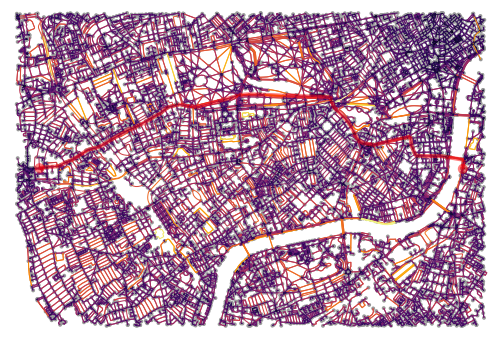

In [1]:
"""Find the least cost path from source to target by minimising air pollution."""

from typing import Optional, Tuple
import logging
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import networkx as nx
import math
from cleanair.databases.queries import AirQualityResultQuery
from cleanair.loggers import get_logger
from shapely.geometry import Polygon

from routex.types import Node
from urbanroute.geospatial import update_cost, ellipse_bounding_box
from urbanroute.queries import HexGridQuery


def main(  # pylint: disable=too-many-arguments
    secretfile: str = "/home/james/clean-air-infrastructure/.secrets/db_secrets_ad.json",
    instance_id: str = "d5e691ef9a1f2e86743f614806319d93e30709fe179dfb27e7b99b9b967c8737",
    sourceLat: float = 51.4929,
    sourceLong: float = -0.1215,
    start_time: Optional[str] = "2020-01-24T09:00:00",
    targetLat: float = 51.4929,
    targetLong: float = -0.2215,
    upto_time: Optional[str] = "2020-01-24T10:00:00",
    verbose: Optional[bool] = False,
):
    """
    secretfile: Path to the database secretfile.
    instance_id: Id of the air quality trained model.
    sourceLat: latitude of the source point.
    sourceLong: longitude of the source point.
    targetLat: latitude of the target point.
    targetLong: longitude of the target point.
    
    """
    source = (sourceLat, sourceLong)
    target = (targetLat, targetLong)
    logger = get_logger("Shortest path entrypoint")
    if verbose:
        logger.level = logging.DEBUG

    # TODO change this to a AirQualityResultQuery
    result_query = HexGridQuery(secretfile=secretfile)
    logger.info("Querying results from an air quality model")
    result_sql = result_query.query_results(
        instance_id,
        join_hexgrid=True,
        output_type="sql",
        start_time=start_time,
        upto_time=upto_time,
    )
    logger.debug(result_sql)

    gdf = gpd.GeoDataFrame.from_postgis(
        result_sql, result_query.dbcnxn.engine, crs=4326
    )
    gdf = gdf.rename(columns=dict(geom="geometry"))
    gdf.crs = "EPSG:4326"
    # gdf = gpd.GeoDataFrame(result_df, crs=4326, geometry="geom")
    logger.info("%s rows in hexgrid results", len(gdf))

    if source is not None and target is not None:
        # use bounding box of surrounding ellipse to limit graph size
        box = ellipse_bounding_box((source[1], source[0]), (target[1], target[0]))
        G: nx.MultiDiGraph = ox.graph_from_bbox(box[0], box[1], box[2], box[3])

        # snap source and target to the graph
        newSource = ox.distance.get_nearest_node(G, source)
        newTarget = ox.distance.get_nearest_node(G, target)

        logger.info(
            "%s nodes and %s edges in graph.", G.number_of_nodes(), G.number_of_edges()
        )

        logger.info("Mapping air quality predictions to the road network.")
        G = update_cost(G, gdf, cost_attr="NO2_mean", weight_attr="length")
        logger.debug("Printing basic stats for the graph:")
        logger.debug(ox.stats.basic_stats(G))

        for i, (u, v, k, data) in enumerate(G.edges(keys=True, data=True)):
            if i > 10:
                break
            print(u, v, k, data)

        ev = [
            G.get_edge_data(edge[0], edge[1], edge[2])["NO2_mean"] ** (1 / 2)
            for edge in G.edges
        ]
        norm = colors.Normalize(vmin=min(ev), vmax=max(ev))
        cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
        ec = [cmap.to_rgba(cl) for cl in ev]
        fig, ax = ox.plot_graph_route(
            G,
            nx.dijkstra_path(G, newSource, newTarget, weight="NO2_mean"),
            edge_color=ec,
        )

main()